# Graded exercise: Modeling neurons

Blue Brain Project / EPFL ©2005-2017. This notebook is under a [LGPLv3](https://raw.githubusercontent.com/BlueBrain/MOOC-neurons-and-synapses-2017/master/LICENSE.txt) license.

## Problem description

In this exercise you should find the relationship between the diameter of a dendrite and the attenuation of synaptic EPSPs.

An EPSP is the potential difference caused by the activation of a synapse. Below you find code that shows you the synaptic attenuation. By putting the synapse further and further from the soma, EPSPs become smaller and smaller, i.e. they are attenuated by traveling through the dendrite.

Below you find the code to calculate the [exponential decay constant](https://en.wikipedia.org/wiki/Exponential_decay) of the EPSP amplitude.

Now try to find the relationship between the (uniform) diameter of the dendrite, and the synaptic attenuation. For this vary the diameter (use 'for' loop) between .1 -> 10 micron.

You can use:
diam_range = numpy.linspace(.1, 10.0, 20)

Save the exponential decay constant for each diameter, and plot the log of diam_range against the log of the exponential decay constant.

This should form a linear relationship. Use numpy.polyfit to fit a line to this relationship.

a, b = numpy.polyfit(x, y, 1)

and send us the slope parameter 'a' of the fit.

In [2]:
import os
os.unsetenv('PYTHONHOME') # Solve an issue with NEURON simulator import

%matplotlib inline

!pip install -q bluepyopt==1.5.12 matplotlib==2.0.2 numpy==1.13.0 2>&1 | grep -v 'SNIMissingWarning\|InsecurePlatformWarning'
!pip -q install --upgrade --pre -i https://bbpteam.epfl.ch/repository/devpi/simple/ single-cell-mooc-client | grep -v 'SNIMissingWarning\|InsecurePlatformWarning'

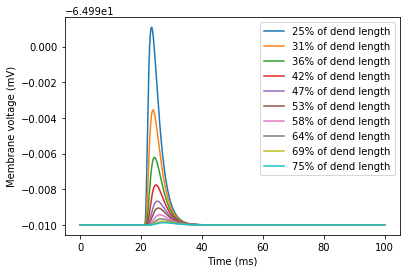

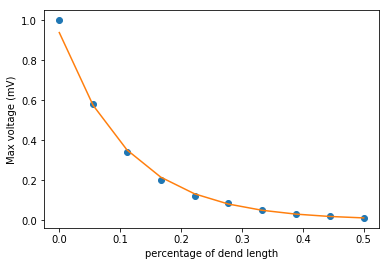

Exponential decay constant of EPSPs: 8.833481


In [3]:
# Init
import neuron
import numpy
import matplotlib.pyplot as plt

neuron.h.load_file("stdrun.hoc");
neuron.h.stdinit();

# Define soma
soma = neuron.h.Section(name='soma')
soma.L = 40
soma.diam = 40
soma.insert('hh');
soma.gl_hh = 5e-4 # Leak conductance, S/cm^2
soma.el_hh = -65 # Reversal potential leak current, mV
soma.gkbar_hh = 0.0 # in S/cm^2
soma.gnabar_hh = 0.0

# Define dendrite
dend = neuron.h.Section(name='dend')
dend.connect(soma, 0)
dend.insert('hh')
dend.el_hh = -65 # Reversal potential leak current, mV
dend.gl_hh = 5e-4 # Leak conductance, S/cm^2
dend.gkbar_hh = 0.0
dend.gnabar_hh = 0.0
dend.L = 400 # micron
dend.diam = 1.0 # micron
dend.nseg = 51 # number of segments in the dendritic section
dend.Ra = 200

# Record voltage
time = neuron.h.Vector()
voltage = neuron.h.Vector()

time.record(neuron.h._ref_t)
voltage.record(dend(0)._ref_v);

def plot_tv(time_array, voltage_array, show=True, label=None, constants=[]):
    import matplotlib.pyplot as plt
    import numpy
    plt.plot(time_array, voltage_array, label=label)
    for constant in constants:
        plt.plot(time_array, constant*numpy.ones(len(time_array)))
    plt.xlabel('Time (ms)')
    plt.ylabel('Membrane voltage (mV)')
    if show:
        plt.show()

voltage_dist = {}
atts = []

dend.diam = 0.1

# Take distance from 25% -> 75% of dendrite to avoid boundary effects
distance_range = numpy.linspace(0.25, .75, 10)

# Add synapse 
for syn_location in distance_range:
    expsyn = neuron.h.ExpSyn(syn_location, sec=dend) 
    
    netstim = neuron.h.NetStim()
    netstim.interval = 1
    netstim.number = 1
    netstim.start = 20
    netstim.noise = 0

    netcon = neuron.h.NetCon(netstim, expsyn)
    netcon.weight[0] = .01
    neuron.h.tstop = 100
    neuron.h.run()

    voltage_dist[syn_location] = numpy.array(voltage)


# Plot voltages for synapse at different distances
for distance in distance_range:
    plot_tv(time, voltage_dist[distance], show=False, label='%.0f%% of dend length' % (distance*100))
plt.legend()
plt.show()

# Store the EPSP sizes
epsp_size = []
for distance in distance_range:
    # Get the EPSP size by subtracting the min (baseline) voltage from the max voltage
    epsp_size.append(max(voltage_dist[distance])-min(voltage_dist[distance]))


# Bring x[0] to 0.0
x = distance_range-distance_range[0]

# Normalize
y = epsp_size/epsp_size[0]


# Fit a linear line to log plot
a, b = numpy.polyfit(x, numpy.log(y), 1)

exp_decay_constant = -a

# Plot the data
plt.plot(x, y, 'o')
# Plot the fit
plt.plot(x, numpy.exp(a*x + b))

plt.xlabel('percentage of dend length')
plt.ylabel('Max voltage (mV)')
plt.show()

print('Exponential decay constant of EPSPs: %f' % exp_decay_constant)

After finishing the exercise, send us in the widget below the 'a' parameter returned by polyfit (as seen in the example above).
So an example answer is "0.1", without the double quotes.

In [4]:
import single_cell_mooc_client as sc_mc
submission_widget = sc_mc.Submission()